In [1]:
#---------------------Import libraries --------------
import os, pickle
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import scipy
import scipy.stats
import glob
import shapely
import matplotlib.pyplot as plt

#--------------------- INSAR4SM functionalities --------------
from insar4sm.classes import INSAR4SM_stack, SM_point
from insar4sm.joblib_progress_bar import tqdm_joblib
from insar4sm.prep_meteo import convert_to_df
from insar4sm.gridding import WGS84_to_UTM


In [2]:
def sm_estimation(stack:INSAR4SM_stack, sm_ind:int, dry_date_manual_flag:bool, dry_date: str)->np.array:
    """Estimates soil moisture using insar4sm functionalities

    Args:
        stack (INSAR4SM_stack): the object of the INSAR4SM_stack class
        sm_ind (int): index of soil moisture estimation point

    Returns:
        np.array: soil moisture estimations from inversion
    """
    sm_point_ts = SM_point(stack, sm_ind)
    sm_point_ts.get_DS_info(stack)
    sm_point_ts.calc_covar_matrix()
    if sm_point_ts.non_coverage or np.all(sm_point_ts.amp_DS==0):
        return np.full(sm_point_ts.n_ifg, np.nan)
    else:
        sm_point_ts.get_DS_geometry(stack)
        sm_point_ts.calc_driest_date()
        if dry_date_manual_flag:
            sm_point_ts.driest_date = pd.to_datetime(dry_date)
        sm_point_ts.calc_sm_sorting()
        sm_point_ts.calc_sm_coherence()
        sm_point_ts.calc_sm_index()
        sm_point_ts.inversion()
        return sm_point_ts.sm_inverted

Input arguments for Arabia case study

In [3]:
# the name of your project
projectname = 'INSAR4SM_burgi_comparison'

# the directory of the topstack processing stack
topstackDir = '/RSL02/SM_Arabia/Topstack_processing'

# time of Sentinel-1 pass.
orbit_time = '15:00:00'

# the AOI geojson file, ensure that AOI is inside your topstack stack
AOI = '/RSL02/SM_Arabia/aoi/arabia_burgi.geojson'

# spatial resolution of soil moisture grid in meters
grid_size = 125 

# You can set manually a dry date (one of your SAR acquisition dates ) or set to None
dry_date = '20180401' 
# set to True in case you provide manually an dry_date
dry_date_manual_flag = True

# the meteorological file. You can either provide an ERA5-land file or a csv file with 3 columns (Datetimes, tp__m, skt__K).
meteo_file = '/RSL02/SM_Arabia/era5/adaptor.mars.internal-1665654570.8663068-23624-3-8bce5925-a7e7-4993-a701-0e05b4e9dabd.nc'
# set to True in case you provide an ERA5-Land file
ERA5_flag = True
# In case you downloaded surface soil moisture from ERA5-land, set to True for comparison purposes
ERA5_sm_flag = True

# soil information datasets (https://soilgrids.org/)
sand_soilgrids = '/RSL02/SM_Arabia/soilgrids/sand.tif'
clay_soilgrids = '/RSL02/SM_Arabia/soilgrids/clay.tif'

# the output directory 
export_dir = '/RSL02/SM_Arabia/{}'.format(projectname)

InSAR4SM pipeline

In [4]:
stack = INSAR4SM_stack(topstackDir = topstackDir,
                       projectname = projectname,
                       AOI = AOI,
                       meteo_file = meteo_file,
                       ERA5_flag = ERA5_flag,
                       sand = sand_soilgrids,
                       clay = clay_soilgrids,
                       orbit_time = orbit_time,
                       export_dir = export_dir)

stack.prepare_datasets()
stack.plot()
stack.get_dry_SARs()
stack.calc_insar_stack()
stack.calc_grid(grid_size = grid_size)

with tqdm_joblib(tqdm(desc="SM Invertions", total=stack.n_sm_points)) as progress_bar:
    sm_estimations_list = Parallel(n_jobs=stack.CPUs, backend="threading")(delayed(sm_estimation)(stack, sm_ind, dry_date_manual_flag, dry_date) for sm_ind in range(stack.n_sm_points))

column_dates = [slc_date.strftime("D%Y%m%d") for slc_date in stack.slc_datetimes]
sm_estimations_df = pd.DataFrame(sm_estimations_list, index = range(stack.n_sm_points), columns = column_dates)

sm_estimations_df['geometry'] = stack.sm_points.values
sm_estimations_gdg = gpd.GeoDataFrame(sm_estimations_df, geometry='geometry')
sm_estimations_gdg.to_file(os.path.join(stack.export_dir,'sm_inversions_{}_{}.shp'.format(projectname,grid_size)))

number of SLCs discovered:  21
creating directory: /RSL02/SM_Arabia/INSAR4SM_burgi_comparison/INSAR4SM_burgi_comparison/INSAR4SM_datasets/slcs
write vrt file for each SLC ...
creating stack directory: /RSL02/SM_Arabia/INSAR4SM_burgi_comparison/INSAR4SM_burgi_comparison/INSAR4SM_datasets/coreg_stack
It seems that you AOI is outside of Topstack region
We will modify your AOI...
It seems that you AOI is outside of Topstack region
We will modify your AOI...
It seems that you AOI is outside of Topstack region
We will modify your AOI...
It seems that you AOI is outside of Topstack region
We will modify your AOI...
It seems that you AOI is outside of Topstack region
We will modify your AOI...
It seems that you AOI is outside of Topstack region
We will modify your AOI...
It seems that you AOI is outside of Topstack region
We will modify your AOI...
write vrt file for stack directory
creating geometry directory: /RSL02/SM_Arabia/INSAR4SM_burgi_comparison/INSAR4SM_burgi_comparison/INSAR4SM_datas

SM Invertions: 100%|██████████| 15073/15073 [22:59:53<00:00,  5.49s/it]   


Visualization using precipitation and InSAR4SM SSM estimations

In [5]:
meteo_files = glob.glob('/RSL02/SM_Arabia/Precipitation/*.nc')
meteo_df = pd.DataFrame()
for meteo_file in meteo_files:
    meteo_file_temp_df = convert_to_df(meteo_file, SM_AOI = AOI, ERA5_flag=True)
    meteo_df = pd.concat([meteo_df, meteo_file_temp_df])

<AxesSubplot:xlabel='Datetimes'>

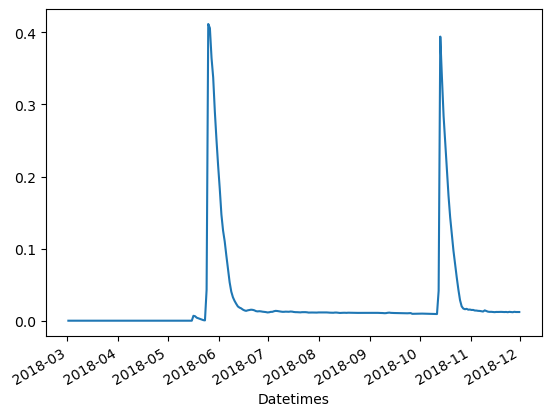

In [6]:
era5_land_file = '/RSL02/SM_Arabia/era5/adaptor.mars.internal-1665654570.8663068-23624-3-8bce5925-a7e7-4993-a701-0e05b4e9dabd.nc'
meteo_df = pd.DataFrame()
for meteo_file in meteo_files:
    meteo_file_temp_df = convert_to_df(era5_land_file, SM_AOI = AOI, ERA5_flag=True)
    meteo_df = pd.concat([meteo_df, meteo_file_temp_df])
meteo_df['swvl1__m**3 m**-3'].plot()